# Multiplane Lensing

The universe is three dimensional and filled with stuff. A light ray traveling to our telescope may encounter more than a single massive object on its way to our telescopes. This is handled by a multiplane lensing framework. Multiplane lensing involves tracing the path of a ray backwards from our telescope through each individual plane (which is treated similarly to typical single plane lensing, though extra factors account for the ray physically moving in 3D space) getting perturbed at each step until it finally lands on the source we'd like to image. For more mathmatical details see [Petkova et al. 2014](https://doi.org/10.1093/mnras/stu1860) for the formalism we use internally.

The main concept to keep in mind is that a lot of quantities we are used to working with, such as "reduced deflection angles" don't really exist in multiplane lensing since these are normalized by the redshift of the source and lens, however there is no single "lens redshift" for multiplane! Instead we define everything with respect to results from full raytracing, once the raytracing is done we can define effective quantities (like effective reduced deflection angle) which behave similarly in intuition but are not quite the same in detail.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from ipywidgets import interact
from astropy.io import fits
import numpy as np

import caustics

In [2]:
# initialization stuff for lenses
cosmology = caustics.FlatLambdaCDM(name = "cosmo")
cosmology.to(dtype=torch.float32)
n_pix = 100
res = 0.05
upsample_factor = 2
fov = res * n_pix
thx, thy = caustics.get_meshgrid(res/upsample_factor, upsample_factor*n_pix, upsample_factor*n_pix, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)

In [3]:
N_planes = 10
N_lenses = 2 # per plane

z_plane = np.linspace(0.1, 1.0, N_planes)
planes = []

for p, z_p in enumerate(z_plane):
    lenses = []
    
    for _ in range(N_lenses):
        lenses.append(
            caustics.PseudoJaffe(
                cosmology = cosmology, 
                z_l = z_p,
                x0 = torch.tensor(np.random.uniform(-fov/3., fov/3.)),
                y0 = torch.tensor(np.random.uniform(-fov/3., fov/3.)),
                mass = torch.tensor(3e10),
                core_radius = 0.01,
                scale_radius = torch.tensor(10**np.random.uniform(-0.5,0.5)),
                s = torch.tensor(0.001),
            )
        )

    planes.append(
        caustics.lenses.SinglePlane(z_l = z_p, cosmology = cosmology, lenses = lenses, name = f"plane_{p}")
    )
    
lens = caustics.lenses.Multiplane(name = "multiplane", cosmology = cosmology, lenses = planes)

## Effective Reduced Deflection Angles

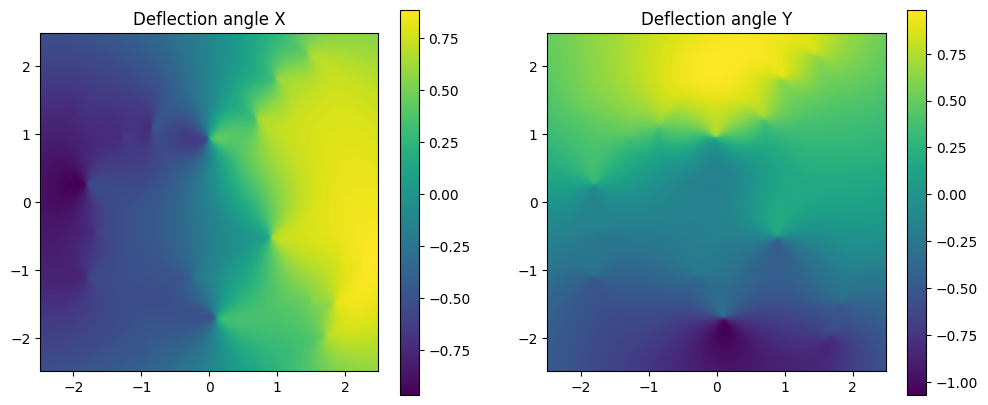

In [4]:
# Effective reduced deflection angles for the multiplane lens system
ax, ay = lens.effective_reduced_deflection_angle(thx, thy, z_s)

# Plot
fig, axarr = plt.subplots(1,2,figsize = (12,5))
im = axarr[0].imshow(ax, extent = (thx[0][0], thx[0][-1], thy[0][0], thy[-1][0]), origin = "lower")
axarr[0].set_title("Deflection angle X")
plt.colorbar(im)
im = axarr[1].imshow(ay, extent = (thx[0][0], thx[0][-1], thy[0][0], thy[-1][0]), origin = "lower")
axarr[1].set_title("Deflection angle Y")
plt.colorbar(im)
plt.show()

## Critical Lines

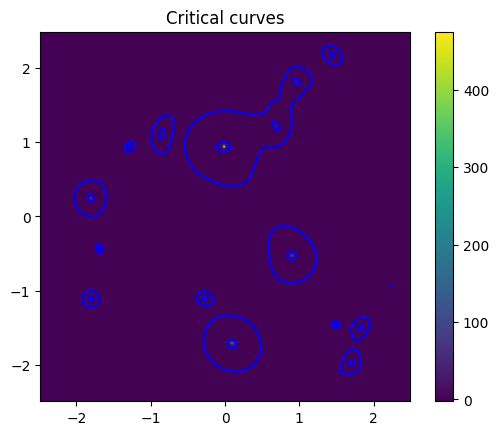

In [5]:
# Compute critical curves using effective difflection angle
A = lens.jacobian_lens_equation(thx, thy, z_s)

# Here we compute detA at every point
detA = torch.linalg.det(A)

# Plot the critical line
im = plt.imshow(detA, extent = (thx[0][0], thx[0][-1], thy[0][0], thy[-1][0]), origin = "lower")
plt.colorbar(im)
CS = plt.contour(thx, thy, detA, levels = [0.], colors = "b")
plt.title("Critical curves")
plt.show()

/tmp/ipykernel_2295161/1690988593.py:2: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = CS.collections[0].get_paths()


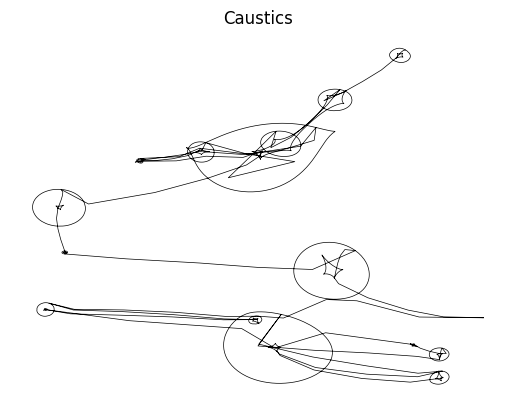

In [6]:
# For completeness, here are the caustics!
paths = CS.collections[0].get_paths()

for path in paths:
    # Collect the path into a descrete set of points
    vertices = path.interpolated(5).vertices
    x1 = torch.tensor(list(float(vs[0]) for vs in vertices))
    x2 = torch.tensor(list(float(vs[1]) for vs in vertices))
    # raytrace the points to the source plane
    y1,y2 = lens.raytrace(x1, x2, z_s)

    # Plot the caustic
    plt.plot(y1,y2, color = "k", linewidth = 0.5)
plt.gca().axis("off")
plt.title("Caustics")
plt.show()

## Effective Convergence

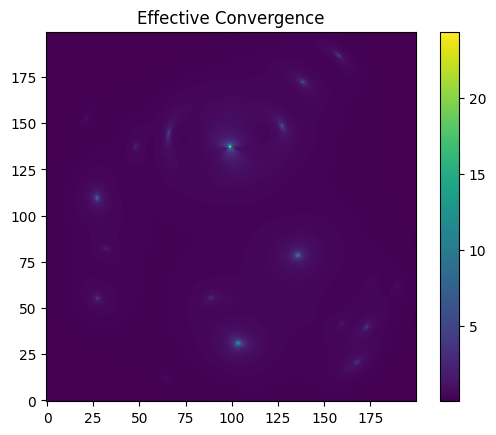

In [7]:
C = lens.effective_convergence_div(thx, thy, z_s)

plt.imshow(C.detach().cpu().numpy(), origin = "lower")
plt.colorbar()
plt.title("Effective Convergence")
plt.show()

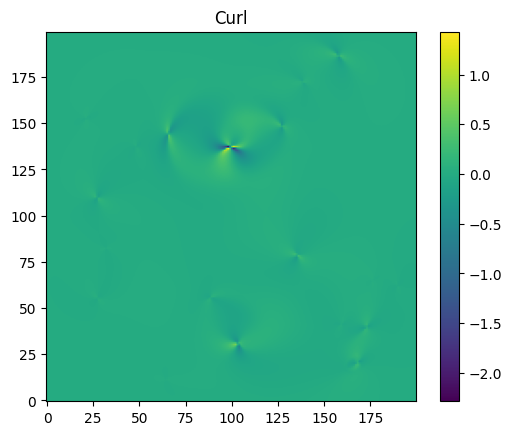

In [8]:
Curl = lens.effective_convergence_curl(thx, thy, z_s)

plt.imshow(Curl.detach().cpu().numpy(), origin = "lower")
plt.colorbar()
plt.title("Curl")
plt.show()